# 01. 센서 데이터 활용 장비 이상진단 및 예측

In [68]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])
from sklearn.metrics import classification_report

## 시나리오 (제품설계자 , 장비 오퍼레이터)
> A공장에서는 최근 도입한 장비로 인하여 골치를 썩고 있다. 새로 도입한 장비의 지속적인 고장으로 인하여 생산 스케줄이 지연되고 있기 때문이다. 해당 장비의 특성상 한 번 고장이 나면 라인 전체를 stop 시켜야 하므로 공정 프로세스에서 Bottleneck 구간이다. 
고장이 나면 공정상 막대한 손해이기 때문에 고장이 나기 전 사전 이상징후를 포착하고 점검을 통해 고장이 발생하여 미치는 손실을 줄이고자 한다.

In [3]:
df_features = pd.read_csv('chapter01_abnormal_features.csv')
df_target = pd.read_csv('chapter01_abnormal_target.csv')

In [4]:
df_features.head(2)
# Time : 센서가 측정되는 시간
# S1~S4 : 센서 고유의 시간

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0


In [5]:
df_target.head()
# X , Y : 센서가 설치된 좌표 
# M : 센서의 충돌이 일어났을 때의 질량
# V : 충돌했을 때의 속ㅁ

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 설비 고장으로 인한 Line stop, 생산 스케줄 지연, 매출감소, 영업이익 감소
```  

> **기대효과**

```
▶ 사전 이상징후 감지 및 점검을 통해 고장으로 인한 Line stop 감소, 생산 스케줄 정상화
```

> **해결방안**

```
▶ 데이터 기반으로 이상징후를 정의하고, 센서 데이터 모니터링을 통해 이상징후 포착 및 실시간 점검
▶ Session 1 🥉
 - 고장이 발생하기 전 이상 증상에 대한 정의  
▶ Session 2 🥈
 - 현업의 노하우, 경험적 지식에 기반한 Rule base 이상진단
▶ Session 3 🥇
 - 모델링을 통한 이상 증상 예측 

```

> **성과측정**  

```
▶ 이상징후 모니터링 전/후 제품 생산량, Line stop 횟수 비교
```

> **현업적용**  

```
▶ 실시간 센서 데이터 수집 및 DB 적재 시스템 구축  
▶ Server에 데이터 모델 탑재 및 특정 시간 단위 실행 및 결과 저장  
▶ 결과 데이터 대시보드 및 BI 시스템에 출력 및 모니터링
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → unique(), value_counts()
▶ session 2 → sns.scatterplot(), plt.axhline(), np.where
▶ session 3 → RandomForestClassifier, classification_report, GridSearchCV
```

In [9]:
# data shape
print(df_features.shape)
print(df_target.shape)

(1050000, 6)
(2800, 5)


In [6]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB


In [10]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2800 non-null   int64  
 1   X       2800 non-null   float64
 2   Y       2800 non-null   float64
 3   M       2800 non-null   float64
 4   V       2800 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 109.5 KB


In [7]:
df_features.describe()

,id,Time,S1,S2,S3,S4
count,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06
mean,1.399500e+03,7.480000e-04,-4.050983e+02,-4.050983e+02,-1.334343e+03,-1.605664e+03
std,8.082907e+02,4.330114e-04,2.753174e+05,2.753174e+05,2.655351e+05,3.026970e+05
min,0.000000e+00,0.000000e+00,-5.596468e+06,-5.596468e+06,-2.772952e+06,-6.069645e+06
25%,6.997500e+02,3.720000e-04,-7.426321e+04,-7.426321e+04,-7.855488e+04,-7.818371e+04
50%,1.399500e+03,7.480000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.099250e+03,1.124000e-03,7.391142e+04,7.391142e+04,7.295836e+04,7.665808e+04
max,2.799000e+03,1.496000e-03,3.865086e+06,3.865086e+06,3.655237e+06,3.687344e+06


In [11]:
df_features.isnull().sum()

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64

In [12]:
df_target.isnull().sum()

id    0
X     0
Y     0
M     0
V     0
dtype: int64

In [13]:
# Unique한 id 개수가 동일한 것으로 보아
# features data가 id당 다수의 데이터를 가지고 있는 것으로 추정.
print("features_unique_id : ", len(df_features['id'].unique()))
print("target_unique_id : ", len(df_target['id'].unique()))

features_unique_id :  2800
target_unique_id :  2800


In [15]:
# 하나의 ID(제품)당 0.000004초의 간격으로 센서 S1-S4에 값이 수집되고 있음.
df_features[df_features['id']==0].head(10)

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0
5,0,0.000020,0.0,0.0,0.0,0.0
6,0,0.000024,0.0,0.0,0.0,0.0
7,0,0.000028,0.0,0.0,0.0,0.0
8,0,0.000032,0.0,0.0,0.0,0.0
9,0,0.000036,0.0,0.0,0.0,0.0


In [16]:
df_features_proc = df_features.groupby('id').mean()

In [17]:
df_features_proc

,Time,S1,S2,S3,S4
id,,,,,
0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893
1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221
2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340
3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867
4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287
...,...,...,...,...,...
2795,0.000748,5600.614397,5885.824925,-6380.192826,-7357.437798
2796,0.000748,-1215.328099,2702.879683,805.983784,-2876.150150
2797,0.000748,436.239993,276.327514,951.805606,-903.193922


In [18]:
# shape이 같아졌음.
print(df_features_proc.shape)
print(df_target.shape)

(2800, 5)
(2800, 5)


In [19]:
# shape이 같아졌으니 이제 merge 
df_merge = pd.merge(df_features_proc, df_target, on='id', how='left')
df_merge.head()

,id,Time,S1,S2,S3,S4,X,Y,M,V
0,0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893,0.0,-400.0,50.0,0.4
1,1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221,400.0,0.0,100.0,1.0
2,2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340,-300.0,-200.0,25.0,0.4
3,3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867,200.0,-100.0,150.0,0.4
4,4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287,-300.0,-100.0,150.0,0.4


In [20]:
df_merge = df_merge.drop(['Time','X','Y'],axis=1)
df_merge.head()

,id,S1,S2,S3,S4,M,V
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4


### 이상(abnormal)의 정의 
---
* 장비가 고장나기 전에 사전 점검을 하기 위한 이상 현상을 정의 
* 자입가 이상에 도달 시 사전 점검을 하기 위함

In [21]:
# 위에서 정의한 것처럼 M(질량) x V(속도) = 최종 충돌 에너지로 정의한 것을 new_col
df_merge['MV'] = df_merge['M'] * df_merge['V']
df_merge.head()

,id,S1,S2,S3,S4,M,V,MV
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0


충돌에너지 평균 : 60.0


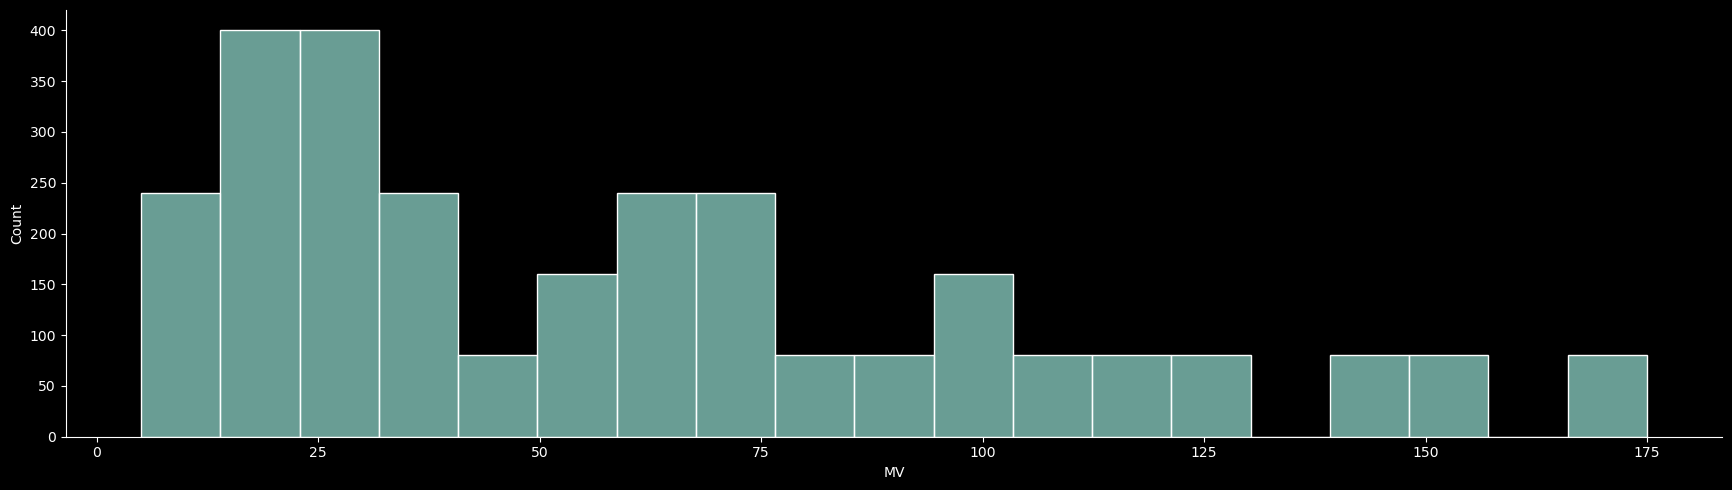

In [24]:
sns.displot(df_merge['MV'])
plt.gcf().set_size_inches(20,5)
print('충돌에너지 평균 :', df_merge['MV'].mean())

In [25]:
# 이상을 정의하는 방법은 다양 , 현업에 기준이 존재할 확률이 큼
# 보통 data의 평균에서 +-1 , 2 , 3  std(표준편차)에서 떨어진 data들을 이상으로 가정.
# mean + 2std 이상인 충돌 에너지를 이상으로 정의
df_merge['abnormal'] = np.where(df_merge['MV'] > df_merge['MV'].mean() + 2*df_merge['MV'].std(),1,0)
df_merge.head()

,id,S1,S2,S3,S4,M,V,MV,abnormal
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0


In [28]:
df_merge[df_merge['abnormal']==1].count()

id          160
S1          160
S2          160
S3          160
S4          160
M           160
V           160
MV          160
abnormal    160
dtype: int64

In [29]:
df_merge['abnormal'].value_counts()
# 약 6% 가 이상징후를 보이고 있음.

0    2640
1     160
Name: abnormal, dtype: int64

## Rule base 이상진단

In [34]:
print("S1_abnormal :",df_merge[df_merge['abnormal']==1]['S1'].mean(),"/ normal :", df_merge[df_merge['abnormal']==0]['S1'].mean())
print("S2_abnormal :",df_merge[df_merge['abnormal']==1]['S2'].mean(),"/ normal :", df_merge[df_merge['abnormal']==0]['S2'].mean())
print("S3_abnormal :",df_merge[df_merge['abnormal']==1]['S3'].mean(),"/ normal :", df_merge[df_merge['abnormal']==0]['S3'].mean())
print("S4_abnormal :",df_merge[df_merge['abnormal']==1]['S4'].mean(),"/ normal :", df_merge[df_merge['abnormal']==0]['S4'].mean())

S1_abnormal : -910.6725618222317 / normal : -374.457459218389
S2_abnormal : -910.6725618222324 / normal : -374.45745931738884
S3_abnormal : -3662.427652993808 / normal : -1193.247454043241
S4_abnormal : -4473.323652485669 / normal : -1431.8663172477716


> **abnormal data와 normal data와의 차이 유의미한 수치**

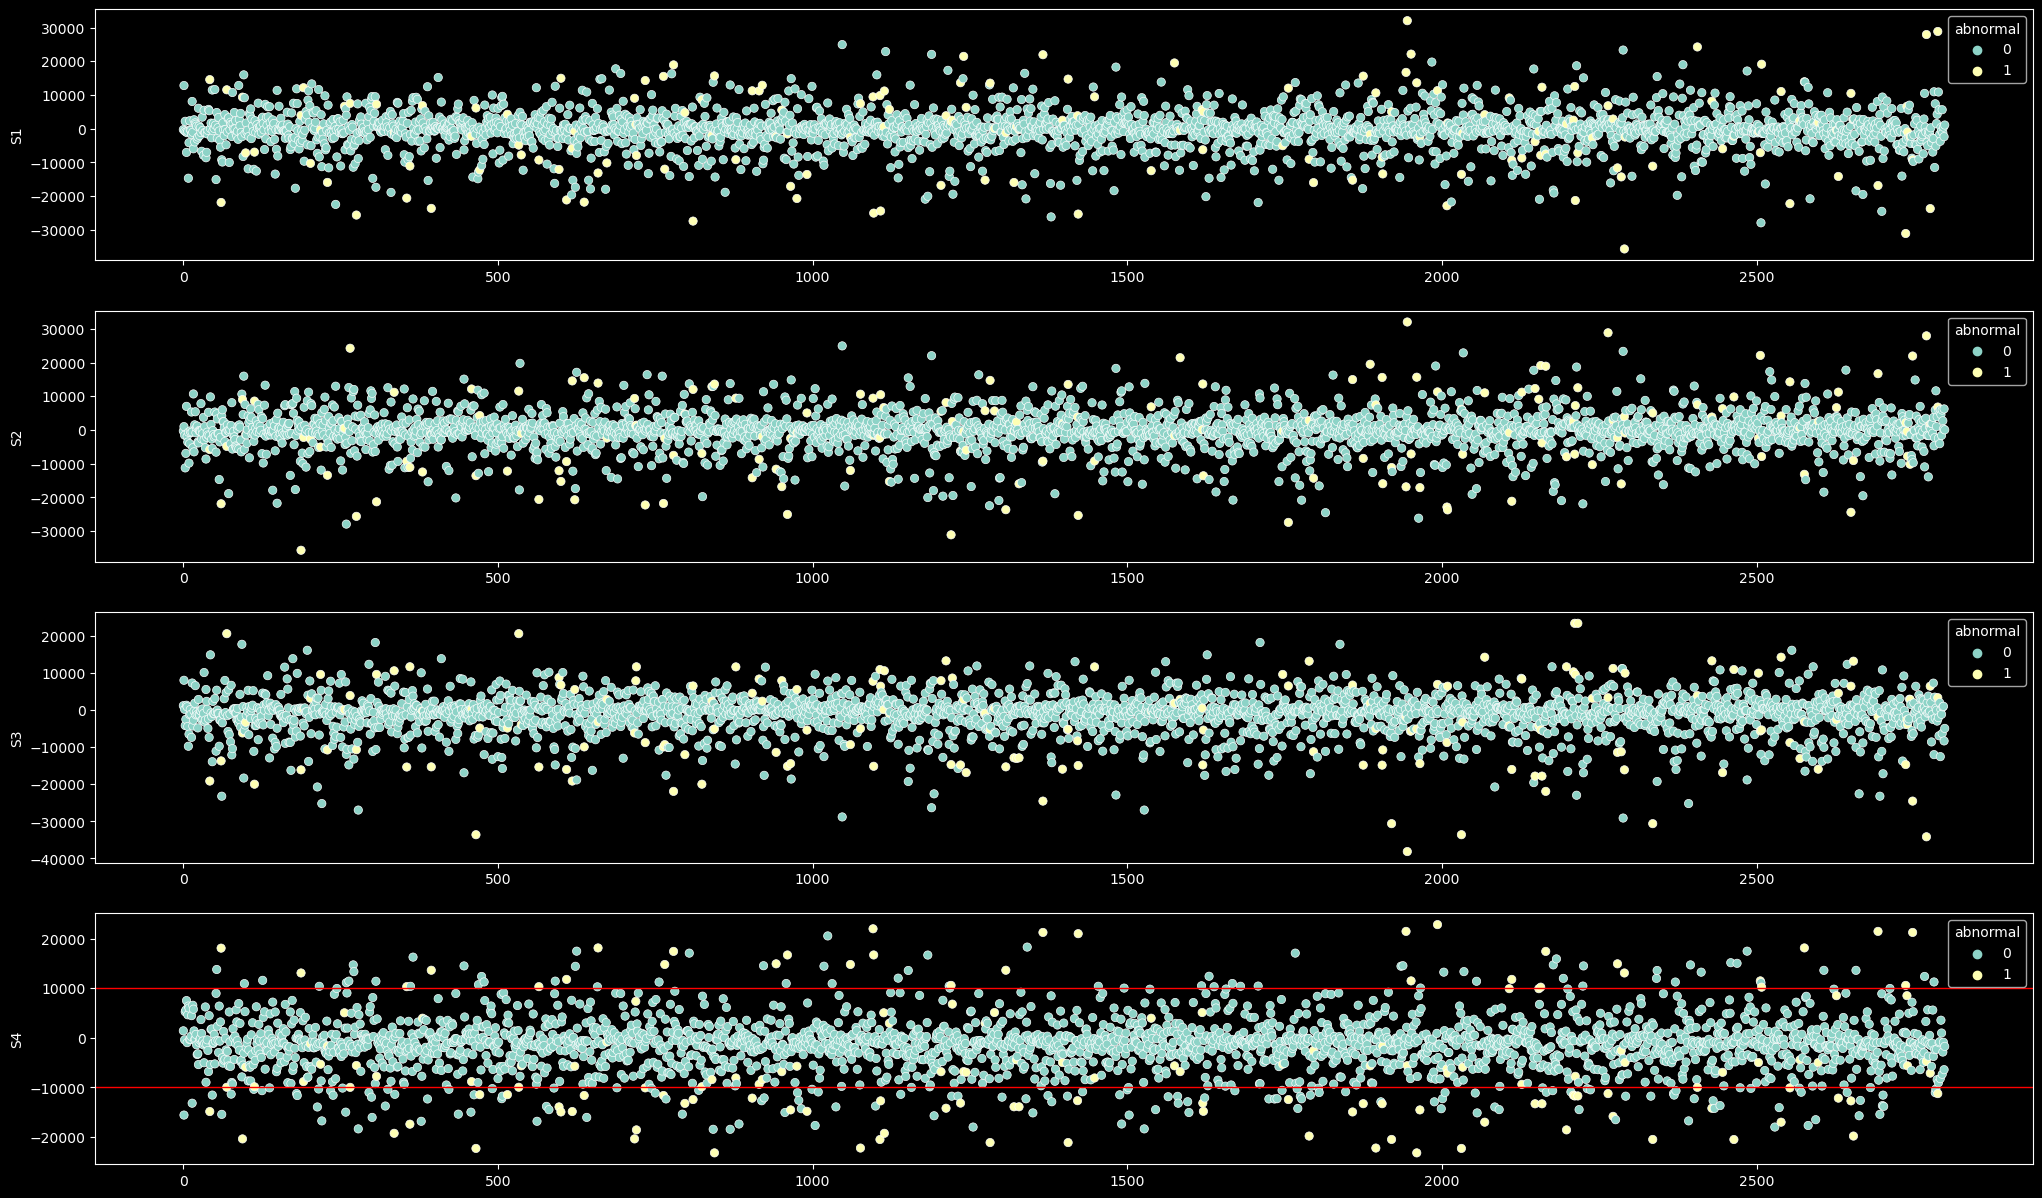

In [41]:
fig,axes = plt.subplots(4,1)
sns.scatterplot(x=df_merge.index, y=df_merge['S1'],hue=df_merge['abnormal'],ax=axes[0]);
sns.scatterplot(x=df_merge.index, y=df_merge['S2'],hue=df_merge['abnormal'],ax=axes[1]);
sns.scatterplot(x=df_merge.index, y=df_merge['S3'],hue=df_merge['abnormal'],ax=axes[2]);
sns.scatterplot(x=df_merge.index, y=df_merge['S4'],hue=df_merge['abnormal'],ax=axes[3]);
# axhline : 그래프에 수평선 그려주는 것.
plt.axhline(y=10000, color='r',linewidth=1)
plt.axhline(y=-10000, color='r',linewidth=1)
# 그래프 사이즈 조정
plt.gcf().set_size_inches(25,15)

* Scatter plot을 통해 각 센서의 값이 10000초과 , -10000미만일 때, 더 많은 불량이 발생하는 인사이트를 확인.
* 실제 평균 이상률(6%) 대비 더 많은 불량이 발생하는지 수치로 확인

In [57]:
# S1 불량률 확인
df_s1 = df_merge[(df_merge['S1'] > 10000) | (df_merge['S1']< -10000)]
df_s1_abnormal_ratio = (len(df_s1[df_s1['abnormal']==1]) / len(df_s1)) * 100
round(df_s1_abnormal_ratio,3)

26.978

In [58]:
# S2 불량률 확인
df_s2 = df_merge[(df_merge['S2'] > 10000) | (df_merge['S2']< -10000)]
df_s2_abnormal_ratio = (len(df_s2[df_s2['abnormal']==1]) / len(df_s2)) * 100
round(df_s2_abnormal_ratio,3)

26.978

In [59]:
# S3 불량률 확인
df_s3 = df_merge[(df_merge['S3'] > 10000) | (df_merge['S3']< -10000)]
df_s3_abnormal_ratio = (len(df_s3[df_s3['abnormal']==1]) / len(df_s3)) * 100
round(df_s3_abnormal_ratio,3)

28.627

In [60]:
# S4 불량률 확인
df_s4 = df_merge[(df_merge['S4'] > 10000) | (df_merge['S4']< -10000)]
df_s4_abnormal_ratio = (len(df_s4[df_s4['abnormal']==1]) / len(df_s4)) * 100
round(df_s4_abnormal_ratio,3)

31.333

In [67]:
df_merge['rule_base1'] = np.where(((df_merge['S1'] > 10000) | (df_merge['S1'] < -10000)), 1, 0)
df_merge['rule_base2'] = np.where(((df_merge['S2'] > 10000) | (df_merge['S2'] < -10000)), 1, 0)
df_merge['rule_base3'] = np.where(((df_merge['S3'] > 10000) | (df_merge['S3'] < -10000)), 1, 0)
df_merge['rule_base4'] = np.where(((df_merge['S4'] > 10000) | (df_merge['S4'] < -10000)), 1, 0)

df_merge.head()

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


# Precision / Recall / F1 Score
---
## Precision (정밀도)
* **분류 모델이 Positive라고 판정한 것 중, 실제로 Positive인 샘플의 비율**
* Precision은 Positive로 검출된 결과가 얼마나 정확한지를 나타낸다. 
> <h2>$ Precision = \frac{TP}{TP + FP} $</h2>
---
## Recall (재현율) 
* **실제 Positive 샘플 중 분류 모델이 Positive로 판정한 비율**
* 분류 모델이 실제 Positive class를 얼마나 빠지지 않고 잘 잡아내는지를 나타낸다.
> <h2>$ Recall = \frac{TP}{TP + FN} $</h2>
---
## Precision - Recall 의 관계 
### < F1-score >
* precision 과 recall의 성능을 동시에 고려하기 위해 F1-score라는 지표를 사용한다. 
* F1-score는 precision 과 recall의 조화평균으로 정의된다. 
* F1-score는 0과 1 사이 값이며 1의 가까울수록 분류 성능이 좋음을 나타냄.
> <h2>$ F1-score = 2 * \frac{Precision * Recall}{Precision + Recall} $</h2>


### < Precision - Recall > 
* Precision과 Recall은 trade-off 관계에 있어, 반비례 관계를 형성한다. 
* Decision threshold를 통해 trade-off관계를 조절할 수 있다. 

---
##### Reference
> **https://ai-com.tistory.com/entry/ML-분류-성능-지표-Precision정밀도-Recall재현율**

In [69]:
# presision : 예측한 것 중 실제로 정답인 비율
# recall : 실제 정답 중 예측으로 맞춘 비율
print(classification_report(df_merge['abnormal'], df_merge['rule_base1']))
print()
print(classification_report(df_merge['abnormal'], df_merge['rule_base2']))
print()
print(classification_report(df_merge['abnormal'], df_merge['rule_base3']))
print()
print(classification_report(df_merge['abnormal'], df_merge['rule_base4']))
print()

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800


              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800


              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2640
           1       0.29      0.46      0.35       160

    accuracy                           0.90      2800
   macro avg       0.63      0.69      0.65      2800
weighted avg       0.93      0.90      0.91      2800


              pr

## ML 활용 이상진단 및 예측
---

In [70]:
df_merge.head()

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df_merge.drop(['id','M','V','MV','rule_base1','rule_base2',
                  'rule_base3','rule_base4','abnormal'],axis=1)
Y = df_merge['abnormal']

# stratify : target data의 쏠림 없이 적절한 비율의 target data로 데이터를 나눠주게 된다.
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1960, 4)
(1960,)
(840, 4)
(840,)


In [75]:
# 모델 학습 
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       112

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       792
           1       0.64      0.44      0.52        48

    accuracy                           0.95       840
   macro avg       0.80      0.71      0.75       840
weighted avg       0.95      0.95      0.95       840



>**위의 학습 결과 , Overfitting 문제 발생 ,train 데이터에 과도하게 높은 성능 , 그러나 test 데이터에 대해 0.44 . . . 로 차이가 많이 난다.**

## Hyper parameter Tuning 

In [76]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [400,500],
         'max_depth' : [6,8,10,12],
         }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행 
rf_clf = RandomForestClassifier(random_state=123456, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1,
                      verbose=2 , scoring='recall')
grid_cv.fit(x_train, y_train)

print('최적의 hyper parameter : ', grid_cv.best_params_)
print('최고 예측 정확도 :{:.4f}'.format(grid_cv.best_score_))

# Cross Validation : 모델을 학습할 때, 겹겹이 검증, 보통 홀수, 3, 5, .. .) 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적의 hyper parameter :  {'max_depth': 10, 'n_estimators': 500}
최고 예측 정확도 :0.4289
[CV] END ......................max_depth=6, n_estimators=400; total time=   1.3s
[CV] END ......................max_depth=8, n_estimators=500; total time=   1.8s
[CV] END .....................max_depth=12, n_estimators=400; total time=   1.8s
[CV] END ......................max_depth=8, n_estimators=400; total time=   1.6s
[CV] END .....................max_depth=10, n_estimators=400; total time=   1.6s
[CV] END .....................max_depth=12, n_estimators=400; total time=   1.7s
[CV] END ......................max_depth=6, n_estimators=400; total time=   1.3s
[CV] END ......................max_depth=8, n_estimators=400; total time=   1.4s
[CV] END .....................max_depth=10, n_estimators=500; total time=   2.3s
[CV] END ......................max_depth=6, n_estimators=500; total time=   1.7s
[CV] END .....................max_depth=10, n_esti

In [77]:
# Best score parameter로 재학습
rfc = RandomForestClassifier(n_estimators=500, max_depth=10,
                            random_state=123456)
rfc.fit(x_train, y_train)

# prediction
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1848
           1       1.00      0.75      0.86       112

    accuracy                           0.99      1960
   macro avg       0.99      0.88      0.92      1960
weighted avg       0.99      0.99      0.98      1960


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       792
           1       0.61      0.40      0.48        48

    accuracy                           0.95       840
   macro avg       0.79      0.69      0.73       840
weighted avg       0.94      0.95      0.95       840



In [78]:
pd.Series(y_pred_train).value_counts()

0    1876
1      84
dtype: int64

## Feature Importance
---
* **Feature IMP 분석을 통한 중요변수 파악**

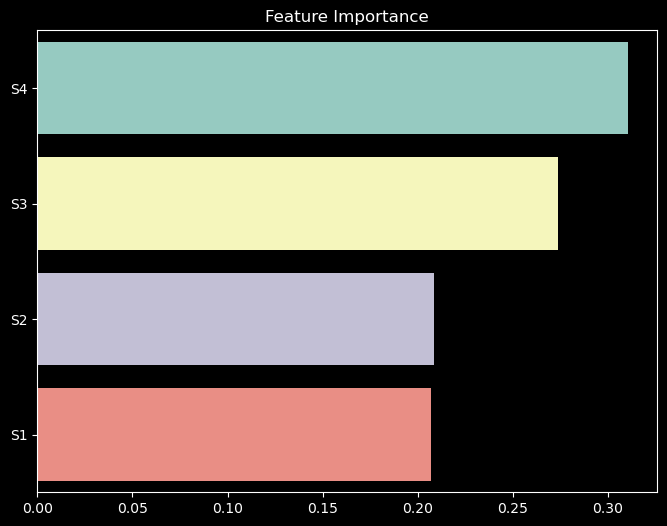

In [79]:
feat_imp_val = rfc.feature_importances_
feat_imp = pd.Series(feat_imp_val, index = x_train.columns)
feat_top20 = feat_imp.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=feat_top20 , y= feat_top20.index)
plt.show()

## 변수 추가 (for upgrade model )

In [80]:
df_new = df_merge.copy()

# 제곱 
df_new['S1_2'] = df_new['S1'] * df_new['S1']
df_new['S2_2'] = df_new['S2'] * df_new['S2']
df_new['S3_2'] = df_new['S3'] * df_new['S3']
df_new['S4_2'] = df_new['S4'] * df_new['S4']

df_new.head()

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4,S1_2,S2_2,S3_2,S4_2
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0,9.505170e+04,9.505170e+04,1.253291e+06,1.989518e+06
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1,1.633329e+08,9.638896e+05,6.325071e+07,2.428846e+08
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0,4.546665e+05,2.482774e+06,1.888707e+04,1.657242e+05
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0,4.683835e+06,1.271195e+08,1.782307e+07,2.747176e+07
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0,9.613422e+05,4.853787e+07,6.531842e+06,3.132564e+07


Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적의 hyper parameter :  {'max_depth': 12, 'n_estimators': 400}
최고 예측 정확도 :0.4462
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1848
           1       1.00      0.84      0.91       112

    accuracy                           0.99      1960
   macro avg       1.00      0.92      0.95      1960
weighted avg       0.99      0.99      0.99      1960


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       792
           1       0.68      0.48      0.56        48

    accuracy                           0.96       840
   macro avg       0.82      0.73      0.77       840
weighted avg       0.95      0.96      0.95       840



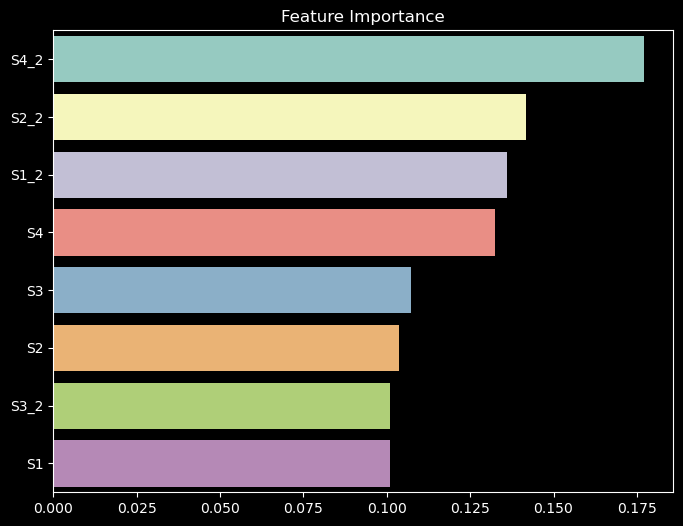

In [81]:
X = df_new.drop(['id','M','V','MV','rule_base1','rule_base2',
                  'rule_base3','rule_base4','abnormal'],axis=1)
Y = df_new['abnormal']

# stratify : target data의 쏠림 없이 적절한 비율의 target data로 데이터를 나눠주게 된다.
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

# 모델 학습 
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

#print(classification_report(y_train, y_pred_train))
#print()
#print(classification_report(y_test, y_pred_test))

params = {'n_estimators': [400,500],
         'max_depth' : [6,8,10,12],
         }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행 
rf_clf = RandomForestClassifier(random_state=123456, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1,
                      verbose=2 , scoring='recall')
grid_cv.fit(x_train, y_train)

print('최적의 hyper parameter : ', grid_cv.best_params_)
print('최고 예측 정확도 :{:.4f}'.format(grid_cv.best_score_))

# Cross Validation : 모델을 학습할 때, 겹겹이 검증, 보통 홀수, 3, 5, .. .)

# Best score parameter로 재학습
rfc = RandomForestClassifier(n_estimators=500, max_depth=10,
                            random_state=123456)
rfc.fit(x_train, y_train)

# prediction
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

feat_imp_val = rfc.feature_importances_
feat_imp = pd.Series(feat_imp_val, index = x_train.columns)
feat_top20 = feat_imp.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=feat_top20 , y= feat_top20.index)
plt.show()

## Model Save & Read

In [ ]:
import pickle

# Save
saved_model = pickle.dumpsp(rfc)

# Read
clf_from_pickle = pickle.loads(saved_model)